In [1]:
%matplotlib inline

In [ ]:
%qtconsole

In [2]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn import mixture
from scipy import stats
from scipy import spatial

## New Plotting Functions

In [3]:
def plot_3d(array3d, title='', ax=None, line=False, color=None, square_axis=False):
    """make 3D scatterplot that plots the x, y, and z columns in a dataframe. Returns figure."""
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
    if square_axis:
        tot_range = (array3d.max(axis=0) - array3d.min(axis=0)).max() * .55
        mn = array3d.mean(axis=0, keepdims=True) - tot_range
        mx = array3d.mean(axis=0, keepdims=True) + tot_range
        limits = np.vstack([mn, mx]).transpose()
        for coord, idx in zip('xyz', range(3)):
            getattr(ax, 'set_{0}lim3d'.format(coord))(limits[idx])
        
    plot_fun = ax.plot if line else ax.scatter
    if color:
        plot_fun(array3d[:,0], array3d[:,2], array3d[:,1], color=color)
    else:
        plot_fun(array3d[:,0], array3d[:,2], array3d[:,1])
    plt.title(title)
    plt.xlabel('x'), plt.ylabel('z')
    return ax

## Load Data and Plot the Point Cloud

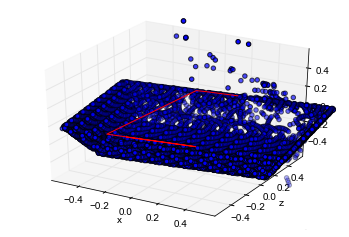

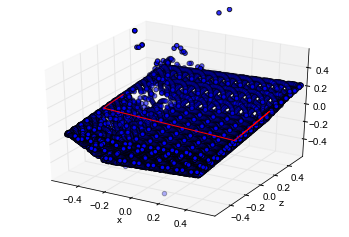

In [8]:
with open('newArenaScan.pickle', 'r') as dfile:
    data = pickle.load(dfile)
    points, markers = np.array(data['markerPos']), np.array(data['body_markers'])

# Offset the markers by the mean Optitrack marker position (the rigid body position)
points -= np.mean(markers, axis=0)

ax = plot_3d(points, title='All Point Data, unfiltered')
plot_3d(markers-markers.mean(axis=0), ax=ax, color='r', line=True, square_axis=True)

def rotate_to_var(markers):
    """Returns degrees to rotate about y axis so greatest marker variance points in +X direction"""
    # Vector in +X direction
    base_vec = np.array([1, 0])
    
    # Vector in direction of greatest variance
    coeff_vec = PCA(n_components=1).fit(markers[:, [0, 2]]).components_  
    marker_var = markers[markers[:,2].argsort(), 2]  # Check variance along component to determine whether to flip.
    winlen = len(marker_var)/2+1  # Window length for moving mean (two steps, with slight overlap)
    var_means = np.array([marker_var[:winlen], marker_var[-winlen:]]).mean(axis=1)
    coeff_vec = coeff_vec * -1 if np.diff(var_means)[0] < 0 else coeff_vec
    
    # Rotation amount, in radians
    msin, mcos = np.cross(coeff_vec, base_vec)[0], np.dot(coeff_vec, base_vec)[0]
    return np.degrees(np.arctan2(msin, mcos))

def y_rotation_matrix(angle):
    """Returns a 3x3 rotation matrix for rotating angle amount (degrees) about the Y axis"""
    angle = np.radians(angle)
    msin, mcos = np.sin(angle), np.cos(angle)
    return np.array([[mcos, 0, msin], [0, 1, 0], [-msin, 0, mcos]])


angle = rotate_to_var(markers)
rot_matrix = y_rotation_matrix(angle)


# Rotate the data in the direction of the markers, so the main variance is in the +x direction


# Since PCA direction could be flipped, point in direction of greatest variance along the first component


points = np.dot(points, rot_matrix)
markers = np.dot(markers-markers.mean(axis=0), rot_matrix)




ax = plot_3d(points, title='All Point Data, unfiltered')
plot_3d(markers, ax=ax, color='r', line=True, square_axis=True)


## New Histogram-Filtering Function

In [10]:

def hist_mask(data, threshold=.95, keep='lower'):
    """
    Returns boolean mask of values below a frequency percentage threshold (0-1).

    Args:
        -data (1D array)
        -threshold (float): 0-1
        -keep (str): lower, greater, middle. If middle, threshold is ignored,
                     and a single cluster is searched out.
    """
    
    bins = len(data)/100 if keep.lower()=='middle' else len(data)/2
    freq, val = np.histogram(data, bins=bins)
    freq = freq / np.sum(freq).astype(float)  # Normalize frequency data

    if keep.lower() in ('lower', 'upper'):
        cutoff_value = val[np.where(np.diff(np.cumsum(freq) < threshold))[0] + 1]
        cutoff_value = val[1] if len(cutoff_value)==0 else cutoff_value
        if keep.lower() == 'lower':
            return data < cutoff_value
        else:
            return data > cutoff_value
    else:
        histmask = np.ones(points.shape[0], dtype=bool)  # Initializing mask with all True values
        
        # Slowly increment the parameter until a strong single central cluster is found
        for param in np.arange(0.0005, .02, .0003):
            cutoff_values = val[np.where(np.diff(freq < param))[0]]
            if len(cutoff_values) == 2:
                histmask &= data > cutoff_values[0]
                histmask &= data < cutoff_values[1]
                return histmask
        else:
            raise ValueError("Histogram filter not finding a good parameter to form a central cluster.")


## Filter out Non-Arena Noise Points (mostly artifacts from reflections)


N Points:
	-Raw Data: 16074
	-Filtered Data: 14575


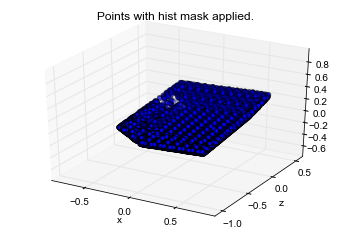

In [12]:
#%matplotlib inline

histmask = np.ones(points.shape[0], dtype=bool)  # Initializing mask with all True values
for coord in range(3):
    histmask &= hist_mask(points[:, coord], keep='middle')
points_f = points[histmask, :]
    
# Plot the masked data    
plot_3d(points_f, title='Points with hist mask applied.', square_axis=True)
print("N Points:\n\t-Raw Data: {0}\n\t-Filtered Data: {1}".format(len(points), len(points_f)))    

## New Function: Get the Normals of the N-Nearest Neighbors cluster

In [13]:
def normal_nearest_neighbors(data, n_neighbors=40):
    """Find the normal direction of a hopefully-planar cluster of n_neighbors"""

    # K-Nearest neighbors on whole dataset
    nbrs = NearestNeighbors(n_neighbors).fit(data)
    _, indices = nbrs.kneighbors(data)

    # PCA on each cluster of k-nearest neighbors
    latent_all, normal_all = [], []
    for idx_array in indices:

        pp = PCA(n_components=3).fit(data[idx_array, :]) # Perform PCA

        # Get the percent variance of each component
        latent_all.append(pp.explained_variance_ratio_) 

        # Get the normal of the plane along the third component (flip if pointing in -y direction)
        normal = pp.components_[2] if pp.components_[2][1] > 0 else -pp.components_[2]
        normal_all.append(normal)

    # Convert to NumPy Array and return
    return np.array(normal_all), np.array(latent_all)



## Get Normals for each point, and filter out points with low planarity

N Points:
	-Raw Data: 16074
	-Hist-Filtered Data: 14575 
	-Hist-and-Norm-Filtered Data: 10116
N Components: 4	BIC: -103953.722012
N Components: 5	BIC: -124442.708653
N Components: 6	BIC: -124378.155538
N Components: 7	BIC: -124313.602422
N Components: 8	BIC: -124249.049307
N Components: 9	BIC: -124184.496192
N Components: 10	BIC: -124119.943077
N Components: 11	BIC: -124055.389961
N Components: 12	BIC: -123990.836846
N Components: 13	BIC: -123926.283731
N Components: 14	BIC: -123861.730616


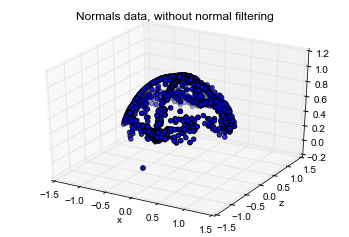

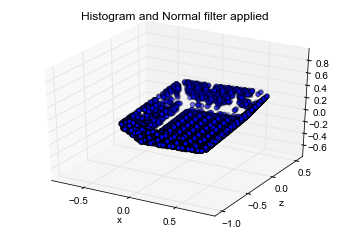

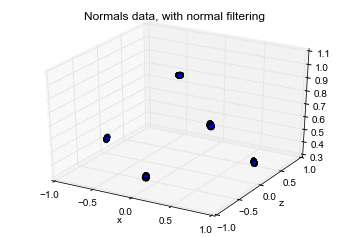

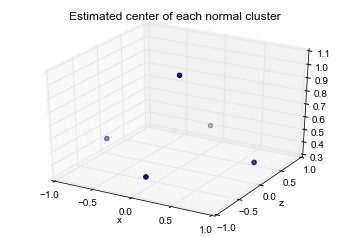

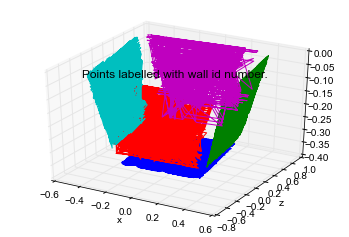

In [16]:
normals_f, explained_variances = normal_nearest_neighbors(points_f)

# Histogram filter: take the 70% best-planar data to fit.
normfilter = hist_mask(explained_variances[:, 2], threshold=.7, keep='lower')
points_ff = points_f[normfilter, :]
normals_ff = normals_f[normfilter, :]


# Plot the new data
plot_3d(normals_f, 'Normals data, without normal filtering')
plot_3d(points_ff, 'Histogram and Normal filter applied', square_axis=True)
plot_3d(normals_ff, 'Normals data, with normal filtering')

print("N Points:\n\t-Raw Data: {0}\n\t-Hist-Filtered Data: {1} "
      "\n\t-Hist-and-Norm-Filtered Data: {2}".format(len(points), len(points_f), len(points_ff)))

def cluster_normals(normal_array, min_clusters=4, max_clusters=15):
    """Returns sklearn model from clustering an NxK array, comparing different numbers of clusters for a best fit."""
    old_bic = 1e32
    for n_components in range(min_clusters, max_clusters):
        gmm = mixture.GMM(n_components=n_components) # Fit the filtered normal data using a gaussian classifier
        temp_model = gmm.fit(normal_array)
        temp_bic = temp_model.bic(normal_array)
        print("N Components: {}\tBIC: {}".format(n_components, temp_bic))
        if temp_bic< old_bic:  # If the new model has a higher BIC than the old one, keep it as a better model.
            model, old_bic = temp_model, temp_bic
            
    return model

model = cluster_normals(normals_ff, min_clusters=4, max_clusters=15)
surface_normals = model.means_  # n_components x 3 normals array, giving mean normal for each surface.

# Calculate mean offset of vertices
ids = model.predict(normals_ff)  # index for each point, giving the wall id number (0:n_components)
surface_offsets = np.zeros_like(surface_normals)
for idx in range(len(surface_normals)):
    surface_offsets[idx, :] = np.mean(points_ff[ids==idx, :], axis=0)



plot_3d(surface_normals, "Estimated center of each normal cluster")

ax = None
for val in range(len(surface_normals)):
    ax = plot_3d(points_ff[ids==val, :], ax=ax, line=True, title='Points labelled with wall id number.')

## Calculate and Floor Plane Vertices

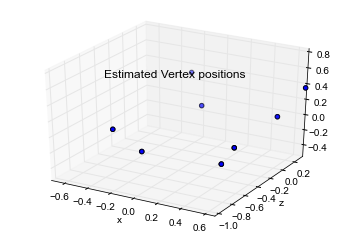

In [20]:
def get_vertices_at_intersections(normals, offsets, ceiling_height):
    """Returns a dict of vertices and normals for each surface intersecton of walls given by the Nx3 arrays of 
    normals and offsets."""
    
    # Calculate d in equation ax + by + cz = d
    dd = np.sum(normals * offsets, axis=1)
    
    # Automatically Separate out the floor from the walls.
    floor_idx = normals[:,1].argsort()[-1]
    wall_normals, wall_d = np.delete(normals, floor_idx, axis=0), np.delete(dd, floor_idx)
    floor_normal, floor_d = normals[floor_idx, :], dd[floor_idx]
    
    # Get neighbors between all walls (excluding the floor, which touches everything.)
    distances = spatial.distance_matrix(wall_normals, wall_normals) + (3 * np.eye(wall_normals.shape[0]))
    neighboring_walls = np.sort(distances.argsort()[:, :2])  # Get the two closest wall indices to each wall
    neighbors =  {dd: el.tolist() for (dd, el) in enumerate(neighboring_walls)}
    
    # Solve for intersection between the floor/ceiling and adjacent walls,
    vertices = {wall: [] for wall in range(len(neighbors))}
    floor_verts = []
    for wall in neighbors:
        for adj_wall in neighbors[wall]:
            for normal, d in ((floor_normal, floor_d), (np.array([0., 1., 0.]), ceiling_height)):
                all_norms = np.vstack((wall_normals[wall], wall_normals[adj_wall], normal))
                all_d = np.array((wall_d[wall], wall_d[adj_wall], d))
                vertex = np.linalg.solve(all_norms, all_d).transpose()
                vertices[wall].append(vertex)
                
                if d < ceiling_height and vertex.tolist() not in floor_verts:
                    floor_verts.append(vertex.tolist())
        
    # Convert vertex lists to dict of NumPy arrays
    vertices = {key: np.array(value) for key, value in vertices.items()}
    vertices[len(vertices)] =  np.array(floor_verts)
    
    norms = {key: np.array(value) for key, value in enumerate(wall_normals)}
    norms[len(norms)] = np.array(floor_normal)
    
    return vertices, norms
    
vertices, normals = get_vertices_at_intersections(surface_normals, surface_offsets, points_ff[:,1].max())

ax = None
for idx, verts in vertices.items():
    ax = plot_3d(verts, ax=ax, title='Estimated Vertex positions', square_axis=True)

## Reorder Vertices about a vertical normal

In [21]:
def reorder_vertices(vertices):
    """Takes an unordered Nx3 vertex array and reorders them to face the same direction as the normal"""
    # Turn the vertex positions to unit-length rays from the mean position (assumes coplanarity)
    vertices = np.array(vertices)
    rays = vertices - np.mean(vertices, axis=0)  
    rays /= np.linalg.norm(rays, axis=1).reshape(-1, 1)  # Normalize their lengths, so we get pure cos and sin values
    
    # Build a covariance matrix, which is the cos values
    cov = np.arccos(np.dot(rays, rays.T) - np.eye(len(rays)))  
    
    # Compare the cross product of each ray combination to the normal, and only keep if the same direction.
    cross_mask = np.zeros_like(cov, dtype=bool)
    for i, ray_i in enumerate(rays):
        for j, ray_j in enumerate(rays):
            cp = np.cross(ray_i, ray_j)
            cross_mask[i, j] = np.dot(cp, [0, 1, 0]) >  0.

    # Apply the filter and reorder the vertices
    cov_filtered = cov * cross_mask
    cov_filtered[cov_filtered==0] = 100.  # Change zeros to a large number, so they aren't taken as the min value.
    new_indices = cov_filtered.argsort()[:,0]
    
    nn_i, idx = [], 0
    for _ in new_indices:
        nn_i.append(new_indices[idx])
        idx = nn_i[-1]
        
    return vertices[nn_i, :]


## Triangulate Those Vertices

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in arccos


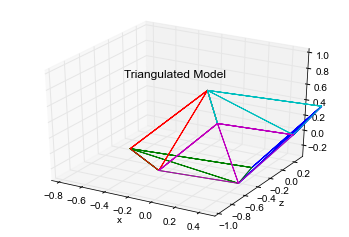

In [23]:
def fan_triangulate(vertices):
    """Return an array of vertices in triangular order using a fan triangulation algorithm."""
    new_verts = []
    vert0 = vertices[0]
    for ii, jj in zip(vertices[1:-1], vertices[2:]):
        new_verts.extend([vert0, ii, jj])
    return np.array(new_verts)

vertices = {wall: fan_triangulate(reorder_vertices(verts)) for wall, verts in vertices.items()}

# Plot    
ax = None
for idx, verts in vertices.items():
    vert_loop = np.vstack((verts, verts[0,:]))  # so the line reconnects with the first point to show a complete outline
    ax = plot_3d(vert_loop, ax=ax, title='Triangulated Model', line=True, square_axis=True)

## Assemble Wavefront .obj file from these vertices and normals

In [24]:
## WRITE WAVEFRONT .OBJ FILE FOR IMPORTING INTO BLENDER ##


def data_to_wavefront(mesh_name, vert_dict, normal_dict):
    """Returns a wavefront .obj string using pre-triangulated vertex dict and normal dict as reference."""

    # Put header in string
    wavefront_str = "# Blender v2.69 (sub 5) OBJ File: ''\n" + "# www.blender.org\n" + "o {name}\n".format(name=mesh_name)

    # Write Vertex data from vert_dict
    for wall in vert_dict:
        for vert in vert_dict[wall]:
            wavefront_str += "v {0} {1} {2} \n".format(*vert)

    # Write (false) UV data
    wavefront_str += "vt 1.0 1.0\n"

    # Write Normal data from normal_dict
    for wall, norm in normal_dict.items():
        wavefront_str += "vn {0} {1} {2}\n".format(*norm)

    # Write Face Indices (1-indexed)
    vert_idx = 0
    for wall in vert_dict:
        for _ in range(0, len(vert_dict[wall]), 3):
            wavefront_str += 'f '
            for vert in range(3): # 3 vertices in each face
                vert_idx += 1
                wavefront_str += "{v}/1/{n} ".format(v=vert_idx, n=wall+1)
            wavefront_str += '\n'
    
    # Return Wavefront string
    return wavefront_str
    

print(data_to_wavefront('MyArena', vertices, normals))

# Blender v2.69 (sub 5) OBJ File: ''
# www.blender.org
o MyArena
v 0.389600553235 -0.0135445982218 0.93088143968 
v 0.547998610699 -0.0135445982218 -0.540973294283 
v 0.366869654374 -0.359026516432 -0.39763812984 
v 0.389600553235 -0.0135445982218 0.93088143968 
v 0.366869654374 -0.359026516432 -0.39763812984 
v 0.243434780838 -0.358938674369 0.749725781017 
v 0.389600553235 -0.0135445982218 0.93088143968 
v 0.243434780838 -0.358938674369 0.749725781017 
v 0.389600553235 -0.0135445982218 0.93088143968 
v 0.389600553235 -0.0135445982218 0.93088143968 
v 0.389600553235 -0.0135445982218 0.93088143968 
v 0.547998610699 -0.0135445982218 -0.540973294283 
v -0.42146276413 -0.0135445982218 -0.646090242212 
v -0.280509651153 -0.35555534554 -0.469469760161 
v 0.366869654374 -0.359026516432 -0.39763812984 
v -0.42146276413 -0.0135445982218 -0.646090242212 
v 0.366869654374 -0.359026516432 -0.39763812984 
v 0.547998610699 -0.0135445982218 -0.540973294283 
v -0.42146276413 -0.0135445982218 -0.64609